<a href="https://colab.research.google.com/github/architect-code/ST463/blob/main/ST463_Stochastic_Simulation%2C_Training_and_Calibration%2C_Seminar_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some general remarks about the code below:



*   As you can see, the code is readable by humans (and not just by the Python interpreter): in general, you have to choose informative function and variable names and use consistent formatting. For instance, you can check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
*   There are some **food for thought**, denoted with $\clubsuit$-$\star$, where $\star$ denote the number of the **food for thought**: you can submit these exercises to me. Their submission is voluntary, but I will be happy to provide detailed feedbacks. If you decide to submit these exercises please create a new .ipynb file named "ST463 - Seminar IV - "YOUR NAME" - "YOUR SURNAME"".
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Text boxes for textual or LaTeX answers (via `+Text`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.

In this Google Colab we see how we can augment financial data with Generative Adversarial Networks (GANs); we will explore how GANs can be used to generate synthetic financial time series data that captures the statistical properties of real data.

Financial data augmentation with GANs involves training a GAN on a real financial time series dataset and using the trained generator network to generate synthetic financial data samples. These synthetic data samples can then be combined with the real data to create an augmented dataset.

The augmented dataset can be used to train predictive models, such as stock price prediction models or anomaly detection models. By training on a larger and more diverse dataset, these models can potentially achieve better performance and generalization.

**DISCUSSION : Why can GANs potentially mode collapse ? Remember there is no guarantee of mode collapse.**

Remember, the goal of the generator $G$ is to fool the discriminator by causing it to assign the generated sample the highest probability of being real as possible. Mathematically, $G$ tries to minimize $\mathbb{E}_{z\sim p_z(z)}[log(1−D(G(z)))]$, or in other words, to generate the point $x=G(z)$ such that $x=\text{argmax}_{x} D(x)$ (of course, we’re assuming that we hold the discriminator fixed for now; we’re merely describing the optimization objective at a given timestep). Note that this $x$ is fixed regardless of the value of $z$, the input to the generator! $x$ only depends on the discriminator at the given timestep. This means that on expectation, there exists a single fixed point that the generator thinks is the most optimal point to generate regardless of whatever input noise we feed it -- there is nothing in the objective function that explicitly forces the generator to generate different samples given the input. During this training step, stochastic gradient descent -- again, on expectation -- would cause the generator to update its weights towards generating this ideal point.

This by itself doesn’t immediately mean mode collapse; during the entirety of the training process, mode collapse may happen only partially or not at all. Since training is a stochastic process, during the beginning stages in training the generated samples will vary depending on $z$ and the samples drawn from the real distribution will also vary -- this means that gradients backpropagated to the generator will vary between training steps depending on the generated and real samples. Moreover the discriminator, ideally, should be able to identify generator mode collapse while it’s happening and assign the collapse point a low probability to force the generator to spread out. This is why we do see training runs succeed in GAN/DCGAN-based models.

But in practice, especially in default GAN models, mode collapse happens quite often. The discriminator ends up not really forcing more diversity in the generator, so much as simply pushing the partially collapsed generator to a different part of output space -- if it assigns the collapse point a low probability, the generator will simply move its collapsed distribution to focus on a new output point. And finally, in the case where the generator has actually collapsed to a single point, it can’t get out; you’ll have to restart your training. To see why this is the case, remember how I said above that the gradient updates to the generator are stochastic, because its generated outputs will vary based on $z$. Well, in the world where the generator is already collapsed, it will emit the same output for every $z$. This means that if you feed a batch of generator outputs to the discriminator and get the gradients back, the generator gradients will all essentially be identical. And they’ll all be racing towards the same maximum point $x^{*}$! Which means the generator will continue to generate the same output regardless of input. Even if the discriminator identifies this and sets the point to low probability, still, the identical gradient updates will cause all outputs of the generator rushing to another fixed point. At this point your training is ruined.

# Setting up the Environment and Data Collection.

We will use the historical stock price data of a banking company. We will download the data using the **yfinance** library and preprocess it for training our GAN.

In [ ]:
import numpy as np
import yfinance as yf

def download_stock_data(ticker, start_date, end_date):
    """
    Download historical stock price data for a given ticker symbol and date range.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    # data is a Pandas DataFrame containing the stock price data.
    return data

# This is an important step in training our GAN, as it helps in stabilizing the
# the training process and improving the convergence of the model.
def preprocess_data(data):
    """
    Preprocess the stock price data by normalizing the values between 0 and 1.
    """
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

Now, let us download and preprocess the stock price data.

In [ ]:
# Download stock price data: we will download the historical stock price data for
# JPMorgan Chase & Co (ticker symbol: JPM) from January 1, 2010, to August 31, 2023.

# We then preprocess the closing price data by normalizing it between 0 and 1.

ticker = "JPM"
start_date = "2015-01-01"
end_date = "2015-01-31"
data = download_stock_data(ticker, start_date, end_date)

# Preprocess data
normalized_data, min_val, max_val = preprocess_data(data["Close"].values)

[*********************100%%**********************]  1 of 1 completed


$\clubsuit$-1 Verify on the downloaded time-serie the empirical stylized facts discussed during the Lecture IV.

Now, we visualize the preprocessed data.

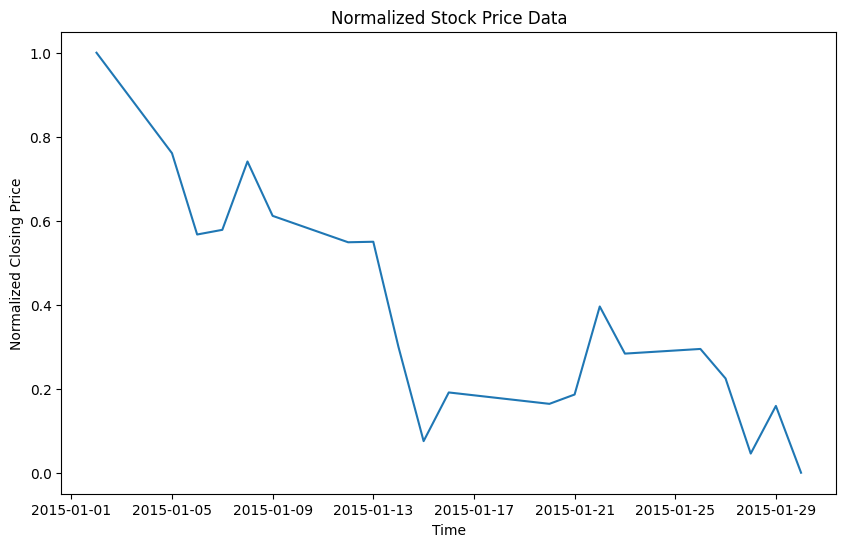

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot Normalized Data
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(data.index)['Date'], normalized_data)
plt.xlabel("Time")
plt.ylabel("Normalized Closing Price")
plt.title("Normalized Stock Price Data")

plt.show()

# Building the Generator Network.

The generator network is responsible for generating synthetic financial data samples. In our case, the generator will generate synthetic stock price data that resembles the real data.

We define a simple feedforward neural network with three hidden layers. The input dimension of the generator network is the noise vector size and the output dimension is the size of the synthetic data sample.

We use the LeakyReLU activation function to introduce non-linearity in the network and prevent the generator from collapsing to a single point. The final layer uses the tanh activation function to ensure that the generated data samples are within the range of [-1, 1].

In this example, we set the input dimension of the generator to 15, which means that the generator will take a noise vector of size 15 as input and generate a synthetic data sample of the same size as the real data.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

def build_generator(input_dim, output_dim):
    """
    Build the generator network.
    """
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(output_dim, activation="tanh"))
    return model

input_dim = 15
output_dim = 1 # Close prices
generator = build_generator(input_dim, output_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Building the Discriminator Network.

The discriminator network is responsible for distinguishing between real and fake data samples. It learns to classify whether a given data sample is real or generated by the generator network.

In this example, we define a simple feedforward neural network with two hidden layers. The input dimension of the discriminator network is the size of the data sample and the output dimension is 1, representing the probability of the data sample being real.

We use the LeakyReLU activation function to introduce non-linearity in the network and prevent the discriminator from becoming too confident. The dropout layers help in regularizing the network and prevent overfitting.

In [ ]:
def build_discriminator(input_dim):
    """
    Build the discriminator network.
    """
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    return model

discriminator = build_discriminator(output_dim)

# Training the GAN

Now that we have defined the generator and discriminator networks, we can proceed with training the GAN. The training process involves alternating between training the discriminator and training the generator.

In this example, we define the training procedure for the GAN. We alternate between training the discriminator and training the generator for a specified number of epochs.

During each training iteration, we select a random batch of real data samples and a batch of synthetic data samples generated by the generator. We then train the discriminator to correctly classify between real and fake data samples.

Next, we generate a batch of noise vectors and train the generator to generate synthetic data samples that fool the discriminator.

The training progress is printed after each epoch, showing the discriminator loss and the generator loss.

In [ ]:
from keras.optimizers import Adam

def train_gan(generator, discriminator, combined, X_train, epochs, batch_size, min_val, max_val):
    """
    Train the GAN.
    """
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]

        # Generate a batch of synthetic data
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        synthetic_data = generator.predict(noise)

        # Denormalize the synthetic data
        synthetic_data = synthetic_data * (max_val - min_val) + min_val

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(synthetic_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Generate a batch of noise vectors
        noise = np.random.normal(0, 1, (batch_size, input_dim))

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss[0]} | G loss: {g_loss}")

# Set hyperparameters
epochs = 150
batch_size =15

# Build the combined GAN model
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])
discriminator.trainable = False
combined = Sequential([generator, discriminator])
combined.compile(loss="binary_crossentropy", optimizer=Adam())

In [ ]:
# Reshape the data for training
X_train = normalized_data.reshape(-1, output_dim)

# Train the GAN
train_gan(generator, discriminator, combined, X_train, epochs, batch_size, min_val, max_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1/150 | D loss: 0.8164117932319641 | G loss: [array(0.9386399, dtype=float32), array(0.9386399, dtype=float32), array(0.4, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 2/150 | D loss: 0.9056180119514465 | G loss: [array(0.95442086, dtype=float32), array(0.95442086, dtype=float32), array(0.46666667, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 3/150 | D loss: 0.9415654540061951 | G loss: [array(0.9813297, dtype=float32), array(0.9813297, dtype=float32), array(0.46666667, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 4/150 | D loss: 0.9363604784011841 | G loss: [array(0.93186957, dtype=float32), array(0.93186957, dtype=float32), array(0.48333332, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 5/150 | D loss: 0.8932143449783325 | G loss: [array(0.8813858, dtype=float32), array(0.8813858, dtype=float32), array(0.50666666, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 6/150 | D

# Generating Synthetic Financial Data

Once the GAN is trained, we can use the generator network to generate synthetic financial data samples. These synthetic data samples will capture the statistical properties of the real data and can be used to augment the original dataset.



In [ ]:
# Generate synthetic data
num_samples = normalized_data.size
noise = np.random.normal(0, 1, (num_samples, input_dim))
synthetic_data = generator.predict(noise)

# Denormalize the real data
normalized_data = normalized_data * (max_val - min_val) + min_val

# Denormalize the synthetic data
synthetic_data = synthetic_data * (max_val - min_val) + min_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


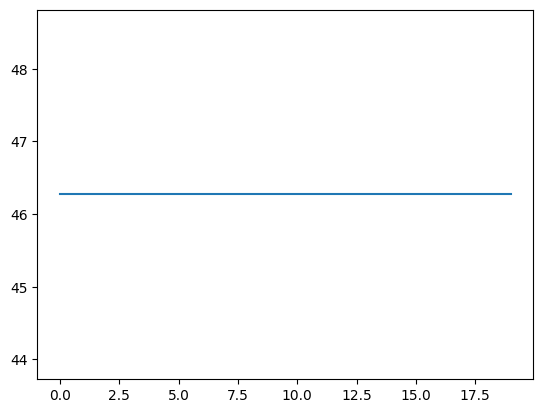

In [ ]:
plt.plot(synthetic_data)

In this example, we generate 1000 synthetic data samples by sampling noise vectors from a normal distribution and passing them through the generator network. We then denormalize the synthetic data to obtain the actual stock price values.

Let’s visualize the synthetic data along with the real data to compare:



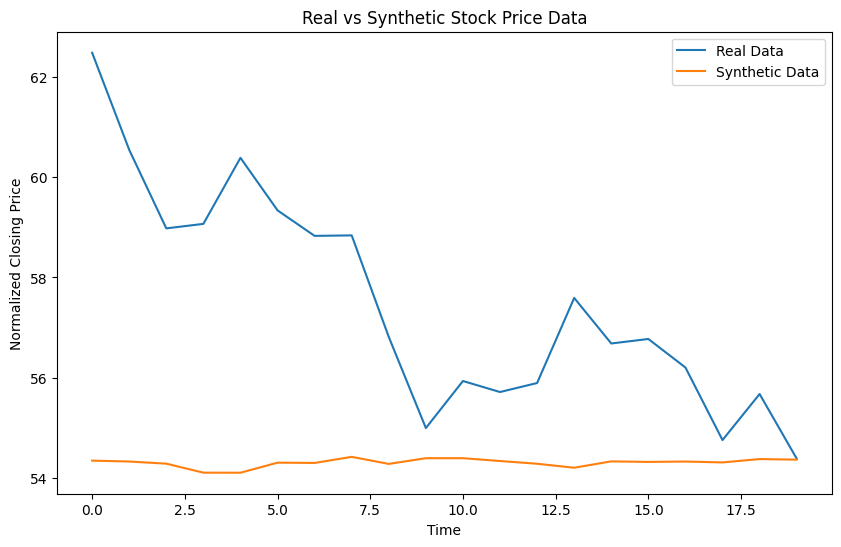

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_data, label="Real Data")
plt.plot(synthetic_data, label="Synthetic Data")
plt.xlabel("Time")
plt.ylabel("Normalized Closing Price")
plt.title("Real vs Synthetic Stock Price Data")
plt.legend()

plt.show()

In [ ]:
real_mean = np.mean(normalized_data)
real_std = np.std(normalized_data)

synthetic_mean = np.mean(synthetic_data)
synthetic_std = np.std(synthetic_data)

print("Real Data:")
print(f"Mean: {real_mean}")
print(f"Standard Deviation: {real_std}")
print()
print("Synthetic Data:")
print(f"Mean: {synthetic_mean}")
print(f"Standard Deviation: {synthetic_std}")

Real Data:
Mean: 57.493000221252444
Standard Deviation: 2.153434733563809

Synthetic Data:
Mean: 54.29931640625
Standard Deviation: 0.08213809132575989
